# More Linear Regression!

### Encoding Categorical Variables, Incorporating Interaction and Polynomial Terms, Et Cetera


Today's focus is all about translating raw **data** into useful **information** that a model can understand and properly use. 

## But First - A Recap

In [126]:
# Imports
import pandas as pd
import numpy as np
# Setting random seed for reproducibility
np.random.seed(1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

New dataset for today! Insurance costs

My source: https://www.kaggle.com/mirichoi0218/insurance (they got the idea for cleaning up the original open source data from [Machine Learning with R](https://www.packtpub.com/product/machine-learning-with-r-third-edition/9781788295864))

In [127]:
# read in the data
df = pd.read_csv('data/insurance.csv')

In [128]:
# explore the data
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [130]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


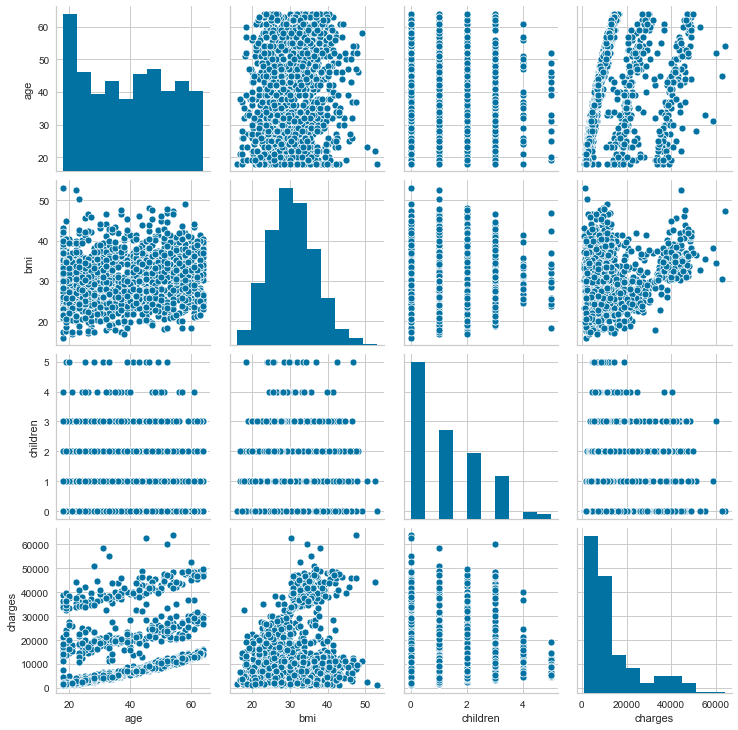

In [131]:
# visualize relationships between numeric columns
sns.pairplot(df)

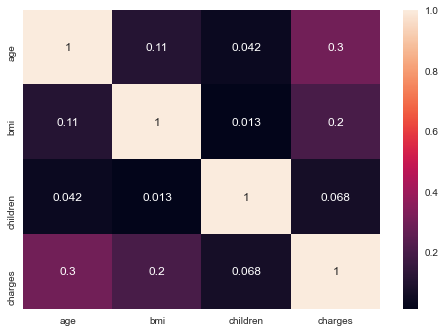

In [132]:
# visualize correlations between numeric columns
sns.heatmap(df.corr(), annot=True)

In [133]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [134]:
# set our X and y
# ignore our categorical columns for now
used_cols = [c for c in df.columns.to_list() if c not in ['sex', 'smoker', 'region', 'charges']]
# not in list is pulling out catagorial variables and the Y
X = df[used_cols]
y = df['charges']

In [135]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [136]:
# scale our data (age and bmi are same scale, but number of children is not)
scaler = StandardScaler()

# train on train data
scaler.fit(X_train)

# transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [137]:
# now, let's model!
lr = LinearRegression ()

lr.fit(X_train_scaled, y_train)

LinearRegression()

In [138]:
# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [139]:
# evaluate
print(f"Train R2 { r2_score(y_train, train_preds)}")
print(f"Test R2 {r2_score(y_test, test_preds)}")
#model only accounts for 11-12% of the variance in our target - this is REAL BAD
print(f"Train RMSE {mean_squared_error(y_train, train_preds, squared=False)}") #set to False to get root mean squared error
print(f"Test RMSE {mean_squared_error(y_test, test_preds, squared=False)}")
# Results mean that model is ~11k off --> also REAL BAD

Train R2 0.11732982143345827
Test R2 0.12733318587824716
Train RMSE 11316.667522752705
Test RMSE 11475.089985058188


In [140]:
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in /opt/anaconda3/envs/learn-env/lib/python3.6/site-packages (1.2)


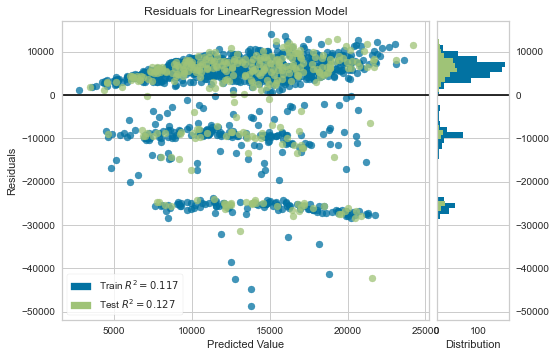

In [141]:
# visualizing our residuals
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure


Ideas to continue improving this model?

- Add categorical variables to predictors
- Apply log trasnform to our very skewed target
- Try different scalers (There was a peak at distribution of age, another scaler may do it better)
- Transform data to convery info more usefully (number of children can be 1 child or many - 0/1 Boolean new column; maybe discrete bins of age that insurance company actually uses then you can categorize by that and utilize that in model to make more applicable)



## Encoding Categorical Variables

How do we bring in those categorical columns? By **encoding** them - translating the string variables into useful numbers the model can hopefully understand and take meaning from.

### Most Common Encoding Method: One Hot Encoding (OHE)

Turns categorical columns into binaries, where each option is turned into its own column.

For our data: we have a column called `region`:

In [142]:
# explore our region column
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [143]:
df['region'].head()

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object

With OHE, the result will either be three or four new columns: `is_southeast`, `is_northwest`, `is_southwest`, `is_northeast`

For the head of this data:

| `is_southeast` | `is_northwest` | `is_southwest` | `is_northeast` |
| -------------- | -------------- | -------------- | -------------- | 
| 0 | 0 | 1 | 0 |
| 1 | 0 | 0 | 0 |
| 1 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 |
| 0 | 1 | 0 | 0 |

Why could it be three? We often drop the first column, and allow the model to capture that value by implying it's vlaue by having zeros in all other columns.

#### With Pandas' `get_dummies()`

In [144]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [145]:
cat_cols = ['sex', 'smoker', 'region']

In [146]:
x_cols = [*used_cols, *cat_cols]

In [147]:
x_cols

['age', 'bmi', 'children', 'sex', 'smoker', 'region']

In [148]:
# one hot encode variables
df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(df_ohe.shape)
df_ohe.head()

(1338, 9)


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


#### With `sklearn`'s One Hot Encoder

In [149]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

In [150]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
# if test set could influence whatebeer you are fitting, you want to fit on the training data alone
encoder = OneHotEncoder(drop='first')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.

ct = ColumnTransformer(transformers=[
    ('ohe', encoder, cat_cols) #name it, tell it what to do encoder, give it columns
], remainder='passthrough') #can do multiple transformers and scalers with ColumnTransform

ct.fit(df[x_cols])
X = ct.transform(df[x_cols])

In [151]:
type(X)

numpy.ndarray

In [152]:
# can display as a dataframe like so
pd.DataFrame(X, columns= ct.get_feature_names()).head()

,ohe__x0_male,ohe__x1_yes,ohe__x2_northwest,ohe__x2_southeast,ohe__x2_southwest,age,bmi,children
0,0.0,1.0,0.0,0.0,1.0,19.0,27.900,0.0
1,1.0,0.0,0.0,1.0,0.0,18.0,33.770,1.0
2,1.0,0.0,0.0,1.0,0.0,28.0,33.000,3.0
3,1.0,0.0,1.0,0.0,0.0,33.0,22.705,0.0
4,1.0,0.0,1.0,0.0,0.0,32.0,28.880,0.0


In [153]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [154]:
# scale our data
scaler = StandardScaler()

# train on train data
scaler.fit(X_train)

# transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
# now, let's model!
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

# grab predictions for train and test set
train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

In [156]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, train_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, test_preds):.3f}")
# 75ish % is MUCH better than 11 - accounts for far more variance
# Still underfit -- Training score is less than test score
print(f"Train RMSE {mean_squared_error(y_train, train_preds, squared=False)}") #set to False to get root mean squared error
print(f"Test RMSE {mean_squared_error(y_test, test_preds, squared=False)}")
# better than 11k off -- ~6k off in predicting charges

Train R2 Score: 0.745
Test R2 Score: 0.767
Train RMSE 6083.132596294014
Test RMSE 5926.023602394469


In [157]:
conda install -c districtdatalabs yellowbrick

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [158]:
from yellowbrick.regressor import ResidualsPlot

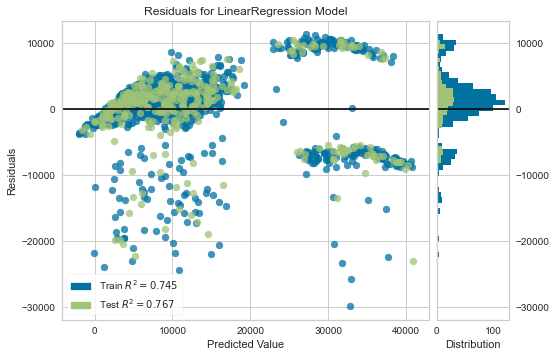

In [159]:
# visualizing our residuals
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

#### Some Pros and Cons of OHE:

Pros:

- Simple to understand
- Easy to implement

Cons:

- If the categorical column has many options, or there are a lot of categorical columns, you can add _a lot_ more columns - **curse of dimensionality**
- Resulting columns are very sparse (mostly zeros)
- Resulting columns are directly related (multicollinear)

### Other Encoding Methods?

Certainly there are other ways to turn a categorical column into numeric data that a model can understand.

Some Examples:

- [Label/Ordinal Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
- [Frequency Encoding](https://contrib.scikit-learn.org/category_encoders/count.html) (just a count encoder with `normalize=True` to turn into a frequency percentage)
- [Target Encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) (or, relatedly, [Leave-One-Out Encoding](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html) or [Weight of Evidence Encoding](https://contrib.scikit-learn.org/category_encoders/woe.html))

Useful links:

- [Category Encoders](https://contrib.scikit-learn.org/category_encoders/index.html) - library of sklearn-style encoders that implement more encoding methods than those actually packaged in Sklearn
- [Sklearn's Preprocessing Section](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) - user guide section on preprocessing (includes scalers and transformers as well as encoders)

## Polynomial Terms - Simple Linear Regression

Demonstrating this on a toy example, with a single x variable predicting y.

In [160]:
# 150 samples from uniform distribution between -2pi and 2pi

x = np.random.uniform(-2*np.pi, 2*np.pi, 150)

# Creating target (y) - so we know the true relationship between x and y
# But - adding some noise (error) with 'np.random'

y = np.sin(x) + np.random.normal(loc=0, scale=0.4, size=len(x))

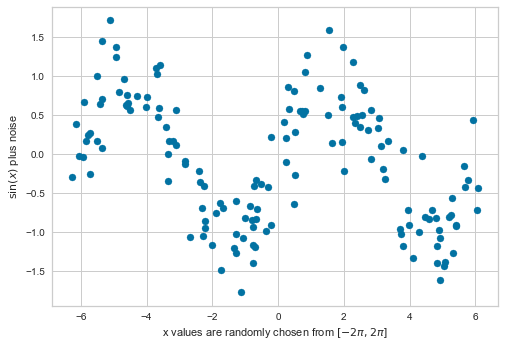

In [161]:
# Visualize it
plt.scatter(x, y)

plt.ylabel('$\sin(x)$ plus noise')
plt.xlabel('x values are randomly chosen from $[-2\pi, 2\pi]$')
plt.show()
#linear in a sense, but curvy

In [162]:
# Fitting a linear model; if know it's not linear, can use polynomial 
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y)

LinearRegression()

In [163]:
# Grabbing the predicted values
y_pred = lr.predict(x.reshape(-1, 1))

In [164]:
# Scoring our model
print(f"R2 Score: {r2_score(y, y_pred)}")

R2 Score: 0.13519811764759415


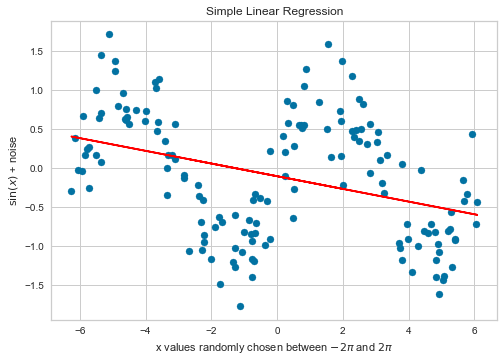

In [165]:
# Visualize it - this is what a linear model looks like on this data
plt.scatter(x, y) # original data

plt.plot(x, y_pred, c='red') # predicted values

plt.ylabel('$\sin(x)$ + noise')
plt.xlabel('x values randomly chosen between $-2\pi$ and $2\pi$')
plt.title("Simple Linear Regression")

plt.show()

Is this a good model? Well - of course not. It's definitely **underfit** - it is not complex enough to accurately capture the pattern and predict the target.

Let's try again, but now with polynomials!

In [166]:
from sklearn.preprocessing import PolynomialFeatures

In [167]:
# For this, we'll need some helper functions
# Shoutout to Andy for sending me these

def create_poly_dataset(x, degree):
    """
    returning dataset with the given polynomial degree
    """
    # Instantiate the PolynomialFeatures object with given 'degree'
    poly = PolynomialFeatures(degree=degree)

    # Now transform data to create higher order features
    new_data = poly.fit_transform(x.reshape(-1, 1))
    return new_data

def fit_linear_model(data, y):
    """
    fitting a linear model and printing model details
    """
    np.set_printoptions(precision=4, suppress=True)

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    lr = LinearRegression(fit_intercept=False)
    lr.fit(data, y)
    print("-"*13)
    print("Coefficients: ", lr.coef_)
    y_pred = lr.predict(data)
    print(f"R-Squared: {lr.score(data, y):.3f}")
    return lr

def plot_predict(x, y, model):
    """
    plotting predictions against true values
    """
    plt.scatter(x, y, label='true')
    x_pred = np.linspace(x.min(), x.max(), 100)
    
    # visualize beyond this x range by uncommenting below:
#     extra = x.ptp() * .2
#     x_pred = np.linspace(x.min() - extra, x.max() + extra, 100)

    plt.plot(x_pred, model.predict(create_poly_dataset(x_pred, len(model.coef_)-1)),
             label='predicted', c='red')

    if len(model.coef_) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms \n (no slope)")
    elif (len(model.coef_) - 1) == 1:
        plt.title(f"{len(model.coef_) - 1} Polynomial Term")
    else:
        plt.title(f"{len(model.coef_) - 1} Polynomial Terms")

    plt.legend()
    plt.show()
    return

-------------
Coefficients:  [-0.0994]
R-Squared: 0.000


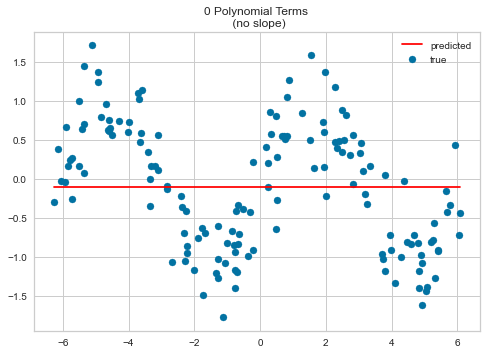

-------------
Coefficients:  [-0.1054 -0.0814]
R-Squared: 0.135


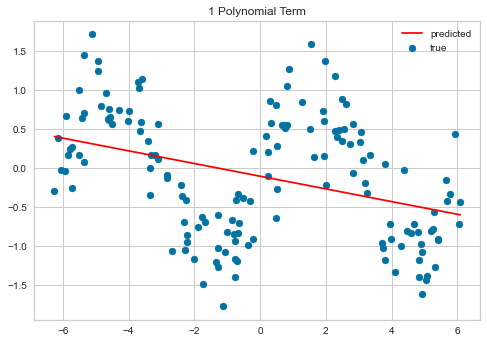

-------------
Coefficients:  [-0.1265 -0.0811  0.0016]
R-Squared: 0.136


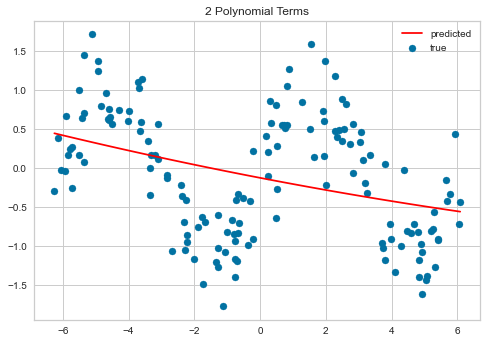

-------------
Coefficients:  [-0.103   0.0832 -0.0008 -0.007 ]
R-Squared: 0.232


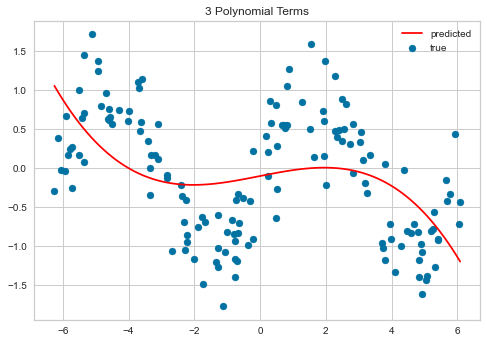

-------------
Coefficients:  [-0.1513  0.6129  0.0149 -0.0714 -0.0003  0.0015]
R-Squared: 0.687


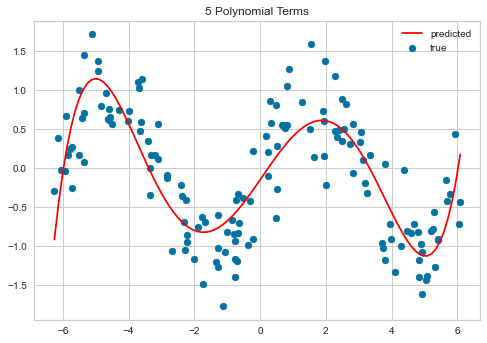

-------------
Coefficients:  [-0.1646  0.9111  0.0319 -0.1402 -0.0017  0.0054  0.     -0.0001]
R-Squared: 0.761


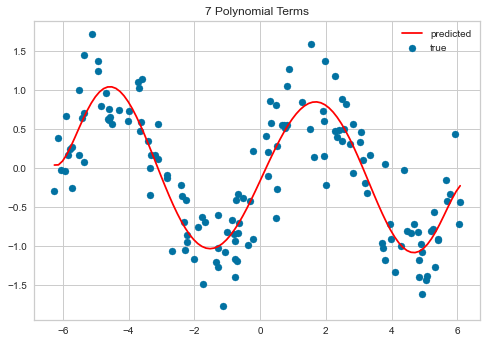

-------------
Coefficients:  [-0.1716  0.9651  0.0424 -0.1604 -0.0032  0.0074  0.0001 -0.0001 -0.
  0.    ]
R-Squared: 0.763


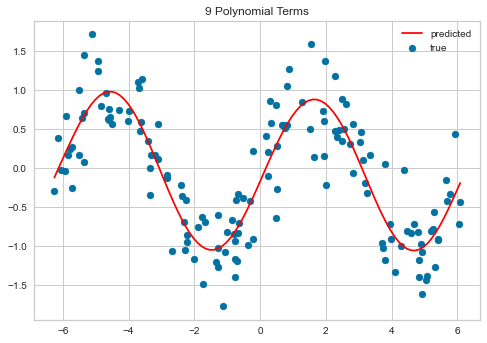

-------------
Coefficients:  [-0.12    1.0427 -0.031  -0.195   0.0133  0.0103 -0.0011 -0.      0.
 -0.     -0.      0.     -0.     -0.    ]
R-Squared: 0.775


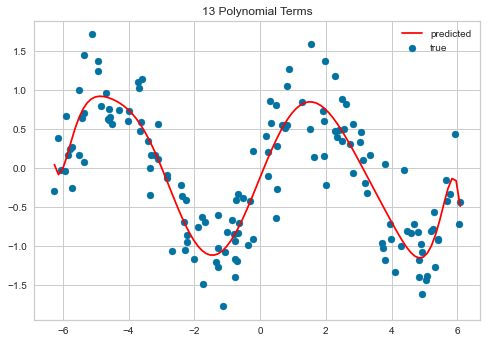

-------------
Coefficients:  [-0.1118  1.2978 -0.0199 -0.5794 -0.0209  0.1608  0.0122 -0.0258 -0.0021
  0.0023  0.0002 -0.0001 -0.      0.      0.     -0.     -0.      0.
  0.    ]
R-Squared: 0.795


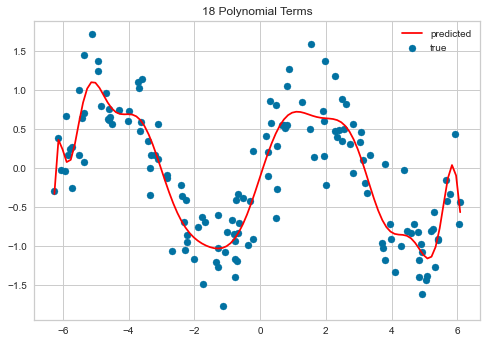

In [168]:
# visualizing an assortment of polynomial degrees
# can visualize each sequential polynomial with `range(n)`
for i in [0, 1, 2, 3, 5, 7, 9, 13, 18]:
    xi = create_poly_dataset(x, i)
    plot_predict(x, y, fit_linear_model(xi, y))

Evaluate: which of these is the best?

- 


Evaluate: so what?

- 


## Interaction Terms

When do we need interaction terms? And how do we check for them?

Well, first things first - what interactions do _you_ think would make sense? That's the easiest way to incorporate interaction terms - use domain knowledge to think through what usefully could be combined into an interaction.

As for how to check if something might be better captured as an interaction...

In [169]:
# add the target back onto our OHE df
df_ohe['target'] = df['charges']

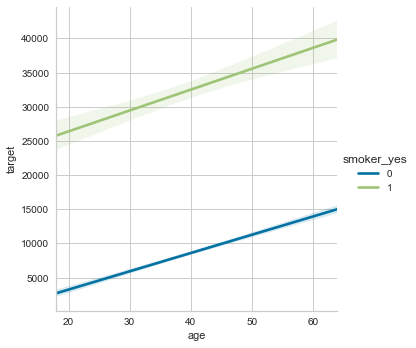

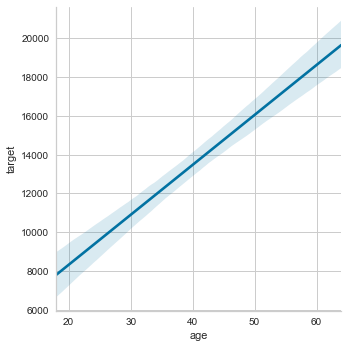

In [170]:
# an example of no interaction term...
sns.lmplot(x='age', y='target', hue='smoker_yes', data=df_ohe, scatter=False)
sns.lmplot(x='age', y='target', data=df_ohe, scatter=False) #smoker doesn't change the slope of the line
plt.show()

How do I know these two variables, `age` and `smoker_yes`, aren't interacting? 

- Look at the slopes - parallel


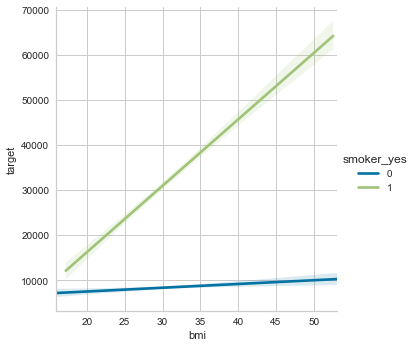

In [171]:
# now let's look at something else...if high BMI and a smoker, the difference is huge; 
# thus could be a useful interaction
# can do this via a for loop comparing
# have domain knowledge and apply it - when there are remodels, house sales price goes up
sns.lmplot(x='bmi', y='target', hue='smoker_yes', data=df_ohe, scatter=False)
plt.show()

What do you think?

- 


## Implementing Interaction and Polynomials in Sklearn

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [172]:
from sklearn.preprocessing import PolynomialFeatures

In [173]:
X = df_ohe.drop(columns = 'target')
y = df_ohe['target']

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

Let's first do Polynomials, to the 3rd degree:

In [175]:
poly = PolynomialFeatures(degree=2, interaction_only=False) 
# interaction only=False means to include interaction terms
# can change degree

In [176]:
poly.fit(X_train)

PolynomialFeatures()

In [177]:
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [178]:
X_train_poly = pd.DataFrame(X_train_poly, columns = poly.get_feature_names())
X_train_poly.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x5^2,x5 x6,x5 x7,x5 x8,x6^2,x6 x7,x6 x8,x7^2,x7 x8,x8^2
0,1.0,24.0,23.655,0.0,2352.96845,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,28.0,26.510,2.0,4340.44090,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,51.0,39.700,1.0,9391.34600,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,47.0,36.080,1.0,42211.13820,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,46.0,28.900,2.0,8823.27900,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [179]:
X_train_poly.columns # too many columns to play around with

Index(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x0^2',
       'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8',
       'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8',
       'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x3^2',
       'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x4^2', 'x4 x5', 'x4 x6',
       'x4 x7', 'x4 x8', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x6^2', 'x6 x7',
       'x6 x8', 'x7^2', 'x7 x8', 'x8^2'],
      dtype='object')

In [180]:
X_train_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 55 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1003 non-null   float64
 1   x0      1003 non-null   float64
 2   x1      1003 non-null   float64
 3   x2      1003 non-null   float64
 4   x3      1003 non-null   float64
 5   x4      1003 non-null   float64
 6   x5      1003 non-null   float64
 7   x6      1003 non-null   float64
 8   x7      1003 non-null   float64
 9   x8      1003 non-null   float64
 10  x0^2    1003 non-null   float64
 11  x0 x1   1003 non-null   float64
 12  x0 x2   1003 non-null   float64
 13  x0 x3   1003 non-null   float64
 14  x0 x4   1003 non-null   float64
 15  x0 x5   1003 non-null   float64
 16  x0 x6   1003 non-null   float64
 17  x0 x7   1003 non-null   float64
 18  x0 x8   1003 non-null   float64
 19  x1^2    1003 non-null   float64
 20  x1 x2   1003 non-null   float64
 21  x1 x3   1003 non-null   float64
 22  

In [181]:
# Still need to scale
scaler = StandardScaler()

scaler.fit(X_train_poly)

X_train_poly_sc = scaler.transform(X_train_poly)
X_test_poly_sc = scaler.transform(X_test_poly)

In [182]:
lr = LinearRegression()

lr.fit(X_train_poly_sc, y_train)

X_train_poly_preds = lr.predict(X_train_poly_sc)
X_test_poly_preds = lr.predict(X_test_poly_sc)

In [183]:
# evaluate - not working out 
print(f"Train R2 Score: {r2_score(y_train, X_train_poly_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, X_test_poly_preds):.3f}")

Train R2 Score: 1.000
Test R2 Score: 1.000


----

In [184]:
interactions = PolynomialFeatures(degree=2, interaction_only=True) #interaction=True only returns interaction terms

interactions.fit(X_train)

PolynomialFeatures(interaction_only=True)

In [185]:
X_train_ints = interactions.transform(X_train)
X_test_ints = interactions.transform(X_test)

In [186]:
X_train_ints = pd.DataFrame(X_train_ints, columns = interactions.get_feature_names())
X_train_ints.head()

,1,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x4 x5,x4 x6,x4 x7,x4 x8,x5 x6,x5 x7,x5 x8,x6 x7,x6 x8,x7 x8
0,1.0,24.0,23.655,0.0,2352.96845,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,28.0,26.510,2.0,4340.44090,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,51.0,39.700,1.0,9391.34600,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,47.0,36.080,1.0,42211.13820,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,46.0,28.900,2.0,8823.27900,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
# Still need to scale
scaler = StandardScaler()

scaler.fit(X_train_ints)

X_train_ints_sc = scaler.transform(X_train_ints)
X_test_ints_sc = scaler.transform(X_test_ints)

In [188]:
lr = LinearRegression()

lr.fit(X_train_ints_sc, y_train)

X_train_ints_preds = lr.predict(X_train_ints_sc)
X_test_ints_preds = lr.predict(X_test_ints_sc)

In [189]:
# evaluate
print(f"Train R2 Score: {r2_score(y_train, X_train_ints_preds):.3f}")
print(f"Test R2 Score: {r2_score(y_test, X_test_ints_preds):.3f}")

Train R2 Score: 1.000
Test R2 Score: 1.000


Evaluate: What do you think? Is this blanket way of approaching polynomial or interaction terms useful?

- The R2 scores are comparable between both instances, so the interaction terms are not useful


## Feature Selection and Feature Importances...

Not much time to do this, but:

- LASSO Regression (L1 regularization)
- Recursive Feature Elimination
- Forward Stepwise Selection

Can always check out the python library [`eli5`](https://eli5.readthedocs.io/en/latest/index.html) (yes, Explain Like I'm 5)

## Resources:

[Feature Engineering and Selection: A Practical Approach for Predictive Models](https://bookdown.org/max/FES/) (computing done in R, but book focuses mostly on discussing the hows and whys rather than focusing on implementation)

- Their chapter on [Encoding Categorical Predictors](https://bookdown.org/max/FES/encoding-categorical-predictors.html)
- And their chapter on [Detecting Interaction Effects](https://bookdown.org/max/FES/detecting-interaction-effects.html)